In [1]:
from pymongo import MongoClient
import os
import tqdm
import pandas as pd
import seaborn as sns
from datetime import date, timedelta

In [2]:
client = MongoClient('mongodb://localhost:27017')
print('Connection Successful')

Connection Successful


In [3]:
# Creating covid_tweets database and tweets collection
db_name = 'covid_tweets'
collection_name = 'tweets'
twdb = client[db_name]
twcollection = twdb[collection_name]

In [4]:
# Iterate files and add to mongodb
DATA_DIR = '../data_sentiment_analysis/data'
for filename in tqdm.tqdm(os.listdir(DATA_DIR)):
    if not filename.endswith('.csv'):
        continue
    full_path = os.path.join(DATA_DIR, filename)
    df = pd.read_csv(full_path, index_col=0)
    df['date_month'] = df['date'].apply(lambda d: d[:-3])
    df.apply(lambda row: twcollection.insert_one(row.to_dict()), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [03:13<00:00,  4.71s/it]


In [5]:
# An example from database
twcollection.find_one()

{'_id': ObjectId('6471b83f73fb4f6f5a3843b7'),
 'id': 1227381392461320192,
 'date': '2020-02-11',
 'url': 'https://twitter.com/bernamadotcom/status/1227381392461320192',
 'lenContent': 143,
 'replyCount': 0,
 'retweetCount': 3,
 'likeCount': 11,
 'quoteCount': 0,
 'lang': 'en',
 'hasLinks': True,
 'hasMedia': True,
 'isRetweeted': False,
 'isQuoted': False,
 'viewCount': nan,
 'bookmarkCount': 0,
 'hasHashtags': True,
 'userId': 106669711,
 'displayName': 'BERNAMA',
 'userDescription': 'Agensi Berita Nasional Malaysia, sejak 1967 / The Malaysian National News Agency, since 1967 - SUMBER BERITA KEPERCAYAAN ANDA / YOUR TRUSTED NEWS SOURCE',
 'verified': False,
 'createDate': '2010-01-20',
 'followerCount': 1155079,
 'friendCount': 253,
 'userLocation': 'Kuala Lumpur, Malaysia',
 'rawContent': '#ICYMI #COVID Ministry detects 19 offences related to face mask, issues compounds of RM67,400 \n\nhttps://t.co/bLlOiWRpyo https://t.co/KXrYuPFei5',
 'compound': -0.34,
 'pos': 0.0,
 'neu': 0.821,
 '

In [6]:
# create date list
day_range = []
month_range = []
start_date = date(2020, 2, 11)
for i in range(365*3+30*3+14):
    iter_date = start_date + timedelta(i)
    day_range.append(iter_date.strftime("%Y-%m-%d"))
    if iter_date.strftime("%Y-%m") not in month_range:
        month_range.append(iter_date.strftime("%Y-%m"))
    
print('Day range is from %s to %s' % (day_range[0], day_range[-1]))
print('Month range is from %s to %s' % (month_range[0], month_range[-1]))

Day range is from 2020-02-11 to 2023-05-24
Month range is from 2020-02 to 2023-05


{'result': 'cnt_pos_daily', 'ok': 1.0}


<Axes: xlabel='date'>

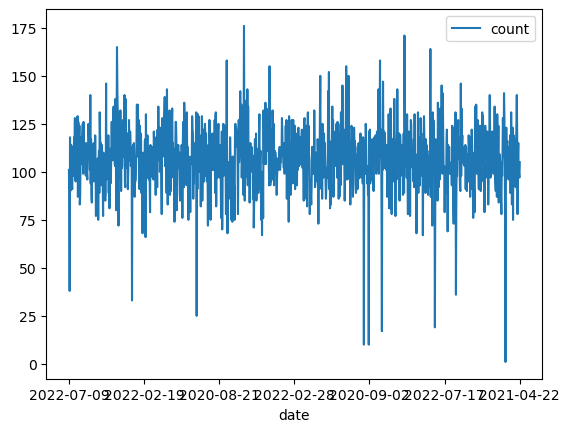

In [7]:
# MapReduce to count positive tweets every day
map_func = """
function() {
    if (this.pos > this.neg) {
        emit({date:this.date}, 1);
    }
}
"""

reduce_func = """
function(keyName, value) {
    return Array.sum(value);
}
"""

mapred_result = twdb.command({
    'mapReduce': collection_name,
    'map': map_func,
    'reduce': reduce_func,
    'out': {'merge': 'cnt_pos_daily'}
})
print(mapred_result)

# Query database to build dictionary
cnt_pos_daily = {}
for c in twdb['cnt_pos_daily'].find():
    cnt_pos_daily[c['_id']['date']] = c['value']
    
# Plot number of positive tweets over time (daily)
df = pd.DataFrame(list(cnt_pos_daily.items()), columns=['date', 'count']).set_index('date')
df.plot()

{'result': 'cnt_neg_daily', 'ok': 1.0}


<Axes: xlabel='date'>

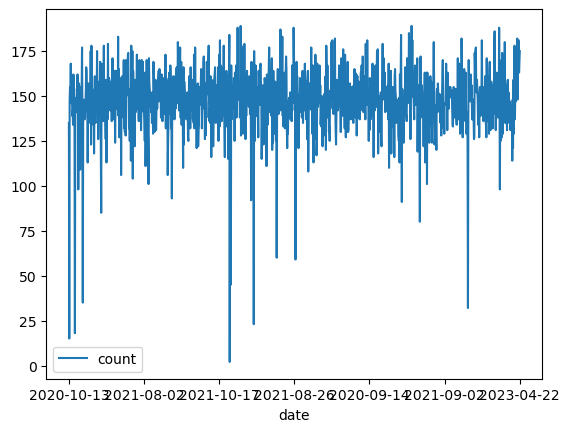

In [8]:
# MapReduce to count negative tweets every day
map_func = """
function() {
    if (this.neg >= this.pos) {
        emit({date:this.date}, 1);
    }
}
"""

reduce_func = """
function(keyName, value) {
    return Array.sum(value);
}
"""

mapred_result = twdb.command({
    'mapReduce': collection_name,
    'map': map_func,
    'reduce': reduce_func,
    'out': {'merge': 'cnt_neg_daily'}
})
print(mapred_result)

# Query database to build dictionary
cnt_neg_daily = {}
for c in twdb['cnt_neg_daily'].find():
    cnt_neg_daily[c['_id']['date']] = c['value']
    
# Plot number of negative tweets over time (daily)
df = pd.DataFrame(list(cnt_neg_daily.items()), columns=['date', 'count']).set_index('date')
df.plot()

<Axes: xlabel='date'>

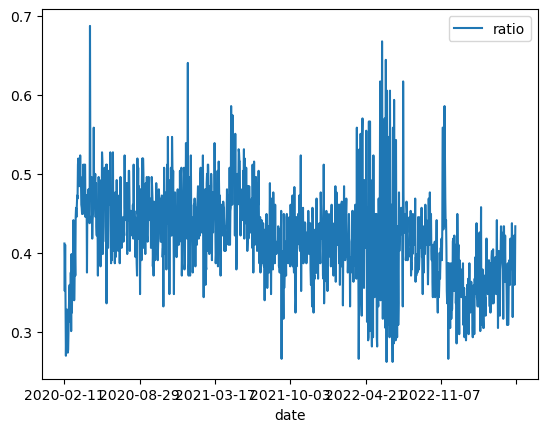

In [9]:
# Find positive tweet ratio daily
pos_ratio_daily = {}
for d in day_range:
    pos_cnt = cnt_pos_daily.get(d, 0)
    neg_cnt = cnt_neg_daily.get(d, 0)
    total = pos_cnt + neg_cnt
    if total > 0:
        ratio = pos_cnt / total
        pos_ratio_daily[d] = ratio

# Create timeseries of positive tweet ratio (daily)
df = pd.DataFrame(list(pos_ratio_daily.items()), columns=['date', 'ratio']).set_index('date')
df.plot()

{'result': 'cnt_pos_monthly', 'ok': 1.0}


<Axes: xlabel='date'>

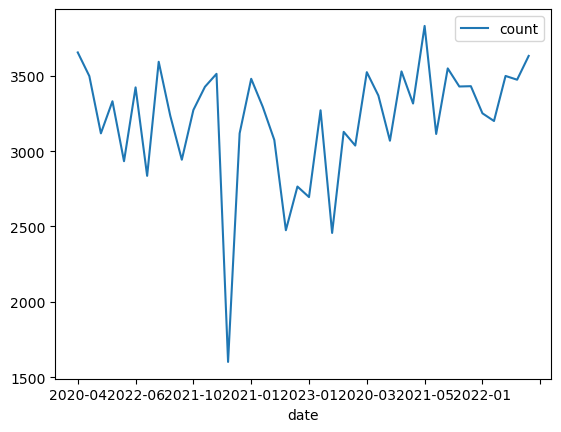

In [10]:
# MapReduce to count positive tweets every month
map_func = """
function() {
    if (this.pos > this.neg) {
        emit({date:this.date_month}, 1);
    }
}
"""

reduce_func = """
function(keyName, value) {
    return Array.sum(value);
}
"""

mapred_result = twdb.command({
    'mapReduce': collection_name,
    'map': map_func,
    'reduce': reduce_func,
    'out': {'merge': 'cnt_pos_monthly'}
})
print(mapred_result)

# Query database to build dictionary
cnt_pos_monthly = {}
for c in twdb['cnt_pos_monthly'].find():
    cnt_pos_monthly[c['_id']['date']] = c['value']
    
# Plot number of positive tweets over time (monthly)
df = pd.DataFrame(list(cnt_pos_monthly.items()), columns=['date', 'count']).set_index('date')
df.plot()

{'result': 'cnt_neg_monthly', 'ok': 1.0}


<Axes: xlabel='date'>

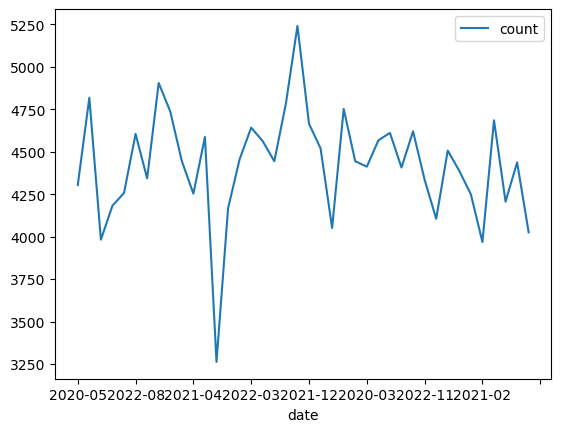

In [11]:
# MapReduce to count positive tweets every month
map_func = """
function() {
    if (this.neg >= this.pos) {
        emit({date:this.date_month}, 1);
    }
}
"""

reduce_func = """
function(keyName, value) {
    return Array.sum(value);
}
"""

mapred_result = twdb.command({
    'mapReduce': collection_name,
    'map': map_func,
    'reduce': reduce_func,
    'out': {'merge': 'cnt_neg_monthly'}
})
print(mapred_result)

# Query database to build dictionary
cnt_neg_monthly = {}
for c in twdb['cnt_neg_monthly'].find():
    cnt_neg_monthly[c['_id']['date']] = c['value']
    
# Plot number of negative tweets over time (monthly)
df = pd.DataFrame(list(cnt_neg_monthly.items()), columns=['date', 'count']).set_index('date')
df.plot()

<Axes: xlabel='date'>

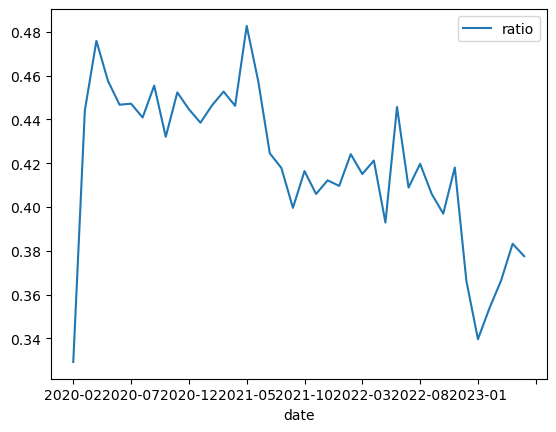

In [12]:
# Find positive tweet ratio daily
pos_ratio_monthly = {}
for m in month_range:
    pos_cnt = cnt_pos_monthly.get(m, 0)
    neg_cnt = cnt_neg_monthly.get(m, 0)
    total = pos_cnt + neg_cnt
    if total > 0:
        ratio = pos_cnt / total
        pos_ratio_monthly[m] = ratio

# Create timeseries of positive tweet ratio (monthly)
df = pd.DataFrame(list(pos_ratio_monthly.items()), columns=['date', 'ratio']).set_index('date')
df.plot()

In [13]:
# Find average of following fields
fields = ['lenContent', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'followerCount', 'friendCount',
          'pos', 'neu', 'neg', 'compound']
field_average_daily = {}
field_average_monthly = {}

for f in fields:
    # Iterate daily and monthly
    for iterate_name, key_field, key_dict in zip(
        ['daily', 'monthly'], ['this.date', 'this.date_month'], [field_average_daily, field_average_monthly]):
        print('Running MapReduce on field %s %s' % (f, iterate_name))
        # Map function for the field per iterated date
        map_func = """
        function() {
            emit({date:%s}, this.%s);
        }
        """ % (key_field, f)
        # Reduce function to average date groups
        reduce_func = """
        function(keyName, value) {
            return Array.avg(value);
        }
        """
        # Temporary collection for MapReduce results
        reduce_collection = 'avg_%s_%s' % (f, iterate_name)
        # Run MapReduce
        mapred_result = twdb.command({
            'mapReduce': collection_name,
            'map': map_func,
            'reduce': reduce_func,
            'out': {'merge': reduce_collection}
        })
        print(mapred_result)
        # Query database to build dictionary
        field_dict = {}
        for c in twdb[reduce_collection].find():
            field_dict[c['_id']['date']] = c['value']
        key_dict[f] = field_dict
        # Remove reduced collection
        twdb.drop_collection(reduce_collection)

Running MapReduce on field lenContent daily
{'result': 'avg_lenContent_daily', 'ok': 1.0}
Running MapReduce on field lenContent monthly
{'result': 'avg_lenContent_monthly', 'ok': 1.0}
Running MapReduce on field replyCount daily
{'result': 'avg_replyCount_daily', 'ok': 1.0}
Running MapReduce on field replyCount monthly
{'result': 'avg_replyCount_monthly', 'ok': 1.0}
Running MapReduce on field retweetCount daily
{'result': 'avg_retweetCount_daily', 'ok': 1.0}
Running MapReduce on field retweetCount monthly
{'result': 'avg_retweetCount_monthly', 'ok': 1.0}
Running MapReduce on field likeCount daily
{'result': 'avg_likeCount_daily', 'ok': 1.0}
Running MapReduce on field likeCount monthly
{'result': 'avg_likeCount_monthly', 'ok': 1.0}
Running MapReduce on field quoteCount daily
{'result': 'avg_quoteCount_daily', 'ok': 1.0}
Running MapReduce on field quoteCount monthly
{'result': 'avg_quoteCount_monthly', 'ok': 1.0}
Running MapReduce on field followerCount daily
{'result': 'avg_followerCount

In [14]:
# Count of fields
fields = ['all', 'hasLinks', 'hasMedia', 'isRetweeted', 'isQuoted', 'hasHashtags', 'verified']
field_count_daily = {}
field_count_monthly = {}

for f in fields:
    # Iterate daily and monthly
    for iterate_name, key_field, key_dict in zip(
        ['daily', 'monthly'], ['this.date', 'this.date_month'], [field_count_daily, field_count_monthly]):
        print('Running MapReduce on field %s %s' % (f, iterate_name))
        # Counting condition (fields are boolean)
        count_condition = 'this.%s' % f
        if f == 'all':
            count_condition = 'true'
        # Map function for the field per iterated date
        map_func = """
        function() {
            if (%s) {
                emit({date:%s}, 1);
            }
        }
        """ % (count_condition, key_field)
        # Reduce function to average date groups
        reduce_func = """
        function(keyName, value) {
            return Array.sum(value);
        }
        """
        # Temporary collection for MapReduce results
        reduce_collection = 'avg_%s_%s' % (f, iterate_name)
        # Run MapReduce
        mapred_result = twdb.command({
            'mapReduce': collection_name,
            'map': map_func,
            'reduce': reduce_func,
            'out': {'merge': reduce_collection}
        })
        print(mapred_result)
        # Query database to build dictionary
        field_dict = {}
        for c in twdb[reduce_collection].find():
            field_dict[c['_id']['date']] = c['value']
        key_dict[f] = field_dict
        # Remove reduced collection
        twdb.drop_collection(reduce_collection)

Running MapReduce on field all daily
{'result': 'avg_all_daily', 'ok': 1.0}
Running MapReduce on field all monthly
{'result': 'avg_all_monthly', 'ok': 1.0}
Running MapReduce on field hasLinks daily
{'result': 'avg_hasLinks_daily', 'ok': 1.0}
Running MapReduce on field hasLinks monthly
{'result': 'avg_hasLinks_monthly', 'ok': 1.0}
Running MapReduce on field hasMedia daily
{'result': 'avg_hasMedia_daily', 'ok': 1.0}
Running MapReduce on field hasMedia monthly
{'result': 'avg_hasMedia_monthly', 'ok': 1.0}
Running MapReduce on field isRetweeted daily
{'result': 'avg_isRetweeted_daily', 'ok': 1.0}
Running MapReduce on field isRetweeted monthly
{'result': 'avg_isRetweeted_monthly', 'ok': 1.0}
Running MapReduce on field isQuoted daily
{'result': 'avg_isQuoted_daily', 'ok': 1.0}
Running MapReduce on field isQuoted monthly
{'result': 'avg_isQuoted_monthly', 'ok': 1.0}
Running MapReduce on field hasHashtags daily
{'result': 'avg_hasHashtags_daily', 'ok': 1.0}
Running MapReduce on field hasHashta

In [15]:
# Create daily dataset
data_daily = {}
for d in day_range:
    data_daily[d] = {}
    data_daily[d]['count_pos_tweets'] = cnt_pos_daily.get(d, 0)
    data_daily[d]['count_neg_tweets'] = cnt_neg_daily.get(d, 0)
    data_daily[d]['ratio_pos_tweets'] = pos_ratio_daily.get(d, 0)
    for f, daily in field_average_daily.items():
        data_daily[d]['average_%s' % f] = daily.get(d, 0)
    for f, daily in field_count_daily.items():
        data_daily[d]['count_%s' % f] = daily.get(d, 0)

df_daily = pd.DataFrame(data_daily).T.sort_index()
df_daily.head(5)

,count_pos_tweets,count_neg_tweets,ratio_pos_tweets,average_lenContent,average_replyCount,average_retweetCount,average_likeCount,average_quoteCount,average_followerCount,average_friendCount,...,average_neu,average_neg,average_compound,count_all,count_hasLinks,count_hasMedia,count_isRetweeted,count_isQuoted,count_hasHashtags,count_verified
2020-02-11,105.0,150.0,0.411765,176.788235,1.721569,1.360784,4.015686,0.290196,31005.600000,4036.368627,...,0.836267,0.062173,0.085574,255.0,104.0,62.0,0.0,24.0,200.0,0.0
2020-02-12,90.0,166.0,0.351562,179.644531,0.445312,1.777344,3.507812,0.207031,35191.207031,1932.832031,...,0.820824,0.089949,0.000945,256.0,147.0,64.0,0.0,28.0,211.0,0.0
2020-02-13,105.0,151.0,0.410156,194.781250,0.457031,1.410156,2.902344,0.300781,61412.281250,2258.347656,...,0.804723,0.095988,-0.002471,256.0,171.0,63.0,0.0,24.0,206.0,0.0
2020-02-14,85.0,171.0,0.332031,188.023438,0.292969,1.054688,2.273438,0.136719,18123.292969,2141.542969,...,0.804508,0.103313,-0.037592,256.0,164.0,43.0,0.0,40.0,206.0,0.0
2020-02-15,69.0,187.0,0.269531,194.898438,0.433594,1.656250,2.652344,0.304688,264127.445312,1915.253906,...,0.811211,0.112777,-0.099611,256.0,154.0,60.0,0.0,35.0,210.0,0.0


In [16]:
df_daily.to_csv('daily_tweets.csv')

In [17]:
client.close()